# Finding Best Place to open a Cafe in Toronto Canada

### Background

One of my friends who was having Subway restaurant had to close his Subway business during May 2020 due to Covid-19 Pandemic which led to reduced sales in his business. Now he is planning to open a Cafe business in Toronto, Canada region. In this project I am planning to help my friend and other business personnel in finding a best location to open Cafe in Toronto using data science concepts that I learned in IBM Data Science Professional Course.

### Introduction/Business Problem

Toronto is capital city of the Ontario, Canada with a population of more than 6 Million in 2016 and with area of 243.3 sq mi. Toronto is international center for business, finance, arts, and culture, and is recognized as one of the most multicultural cities in the world. Toronto economy is diversified with technology, design, financial services, life sciences, education, arts, fashion, aerospace, environmental innovation, food services, and tourism. Starting a Cafe business in such a multicultural and diversified place is not an easy task. We need to consider several factors such as accessibility, visibility, target customers before opening Cafe to be successful in business. Places near business centers, malls, areas with a lot of foot traffic, and tourist attractions will guarantee the steady flow of customers that we need to make a good profit. So, finding a location is one of the most important things in starting a cafe. The search could take months if we start searching and analyzing manually. We can reduce this time to few hours/ days by using machine learning techniques and Four-square location data to find best suitable location to open a Cafe. In this project, we will find the best and most suitable location to open a Cafe in Toronto, Canada for business personal or entrepreneurs.

### Target Audience

- This project is aimed at Business personnel who wants to open a Cafe. 
- The analysis will help entrepreneurs to obtain necessary information in finding the best location for opening a Cafe

### Data Section

 We will use the following data for this project:
1. Toronto data that contains Borough, Neighborhoods along with there latitudes and longitudes
   - Data Source: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
   - Description: This data set contains the required information such as postal code, borough and the name of the    neighbourhoods in city of Toronto
2. Geographical location of the neighbourhoods
   - Data Source: https://cocl.us/Geospatial_data
   - Description:This dataset provides the Geographical coordinates of the neighbourhoods for the respective Postal Codes
3. Venue Data using Foursquare API
   - Data Source: https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}
   - Description: We will use Client_ID, Client_Secret, version details to get all venues for each neighborhood and group data by name of the neighborhood.

### Methodology Section

In [1]:
# import necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import requests
import json
from bs4 import BeautifulSoup
import matplotlib.cm as cm
import matplotlib.colors as colors

%matplotlib inline
print('Packages installed  :)')

Packages installed  :)


In [2]:
# Get the neighborhood data that contains Borough, Neighborhoods along with there latitudes and longitude using beautiful soup 
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
result = requests.get(url)
data_html = BeautifulSoup(result.content)

In [3]:
# Read the data into a Pandas Dataframe
soup = BeautifulSoup(str(data_html))
neigh = soup.find('table')
table_str = str(neigh.extract())

### Dataset 1

#### Example of Toronto dataset that contains Borough, Neighborhoods along with there latitudes and longitudes

In [4]:
df = pd.read_html(table_str)[0]
df.head()

Postal Code           Borough              Neighbourhood
0         M1A      Not assigned               Not assigned
1         M2A      Not assigned               Not assigned
2         M3A        North York                  Parkwoods
3         M4A        North York           Victoria Village
4         M5A  Downtown Toronto  Regent Park, Harbourfront

### Data Cleansing
- The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
- Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
- More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11  in the above table.
- If a cell has a borough but a Not assigned  neighborhood, then the neighborhood will be the same as the borough.

In [5]:
df_dropna = df[df.Borough != 'Not assigned'].reset_index(drop=True)
df_dropna.rename(columns={'Postal Code' : 'PostalCode','Neighbourhood' : 'Neighborhood'}, inplace=True)
df = df_dropna

In [6]:
df.head()

PostalCode           Borough                                 Neighborhood
0        M3A        North York                                    Parkwoods
1        M4A        North York                             Victoria Village
2        M5A  Downtown Toronto                    Regent Park, Harbourfront
3        M6A        North York             Lawrence Manor, Lawrence Heights
4        M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government

In [7]:
df_grouped = df.groupby(['Borough', 'PostalCode'], as_index=False).agg(lambda x:','.join(x))
df_grouped.head()

Borough PostalCode                       Neighborhood
0  Central Toronto        M4N                      Lawrence Park
1  Central Toronto        M4P                   Davisville North
2  Central Toronto        M4R  North Toronto West, Lawrence Park
3  Central Toronto        M4S                         Davisville
4  Central Toronto        M4T        Moore Park, Summerhill East

In [8]:
# Check if we still have any Neighborhoods that are Not Assigned
df_grouped.loc[df_grouped['Borough'].isin(["Not assigned"])]

Empty DataFrame
Columns: [Borough, PostalCode, Neighborhood]
Index: []

In [9]:
df = df_grouped

In [10]:
df.shape

(103, 3)

In [11]:
df = df[['PostalCode', 'Borough', 'Neighborhood']]

In [12]:
df.head()

PostalCode          Borough                       Neighborhood
0        M4N  Central Toronto                      Lawrence Park
1        M4P  Central Toronto                   Davisville North
2        M4R  Central Toronto  North Toronto West, Lawrence Park
3        M4S  Central Toronto                         Davisville
4        M4T  Central Toronto        Moore Park, Summerhill East

### Dataset 2

#### Example dataset of Geographical location of the neighbourhoods

In [13]:
#Geographical location of the neighbourhoods
geo_url = "https://cocl.us/Geospatial_data"

geo_df = pd.read_csv(geo_url)
geo_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
geo_df.head()

PostalCode   Latitude  Longitude
0        M1B  43.806686 -79.194353
1        M1C  43.784535 -79.160497
2        M1E  43.763573 -79.188711
3        M1G  43.770992 -79.216917
4        M1H  43.773136 -79.239476

In [14]:
# Merge the above two datasets
df = pd.merge(df, geo_df, on='PostalCode')
df.head()

PostalCode          Borough                       Neighborhood   Latitude  \
0        M4N  Central Toronto                      Lawrence Park  43.728020   
1        M4P  Central Toronto                   Davisville North  43.712751   
2        M4R  Central Toronto  North Toronto West, Lawrence Park  43.715383   
3        M4S  Central Toronto                         Davisville  43.704324   
4        M4T  Central Toronto        Moore Park, Summerhill East  43.689574   

   Longitude  
0 -79.388790  
1 -79.390197  
2 -79.405678  
3 -79.388790  
4 -79.383160

In [15]:
# list the count of neighborhoods in each borough
df.groupby('Borough').count()['Neighborhood']

Borough
Central Toronto      9
Downtown Toronto    19
East Toronto         5
East York            5
Etobicoke           12
Mississauga          1
North York          24
Scarborough         17
West Toronto         6
York                 5
Name: Neighborhood, dtype: int64

In [16]:
df_toronto = df
df_toronto.head()

PostalCode          Borough                       Neighborhood   Latitude  \
0        M4N  Central Toronto                      Lawrence Park  43.728020   
1        M4P  Central Toronto                   Davisville North  43.712751   
2        M4R  Central Toronto  North Toronto West, Lawrence Park  43.715383   
3        M4S  Central Toronto                         Davisville  43.704324   
4        M4T  Central Toronto        Moore Park, Summerhill East  43.689574   

   Longitude  
0 -79.388790  
1 -79.390197  
2 -79.405678  
3 -79.388790  
4 -79.383160

In [17]:
# Create unique list of Boroughs
boroughs = df_toronto['Borough'].unique().tolist()

In [18]:
# Find the geographical coordinates such as latitude and longitude of Toronto 
lat_toronto = df_toronto['Latitude'].mean()
lon_toronto = df_toronto['Longitude'].mean()
print('The geographical coordinates of Toronto are {}, {}'.format(lat_toronto, lon_toronto))

The geographical coordinates of Toronto are 43.70460773398059, -79.39715291165047


In [19]:
# Assign some random color for each borough
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) 

In [20]:
map_toronto = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=10.5)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], 
                                           df_toronto['Longitude'],
                                           df_toronto['Borough'], 
                                           df_toronto['Neighborhood']):
    label_text = borough + ' - ' + neighborhood
    label = folium.Popup(label_text)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=borough_color[borough],
        fill_color=borough_color[borough],
        fill_opacity=0.8).add_to(map_toronto)  
    
map_toronto

In [21]:
# Provide your Foursquare API client Id and Secret
CLIENT_ID = '1AC0Z0EE5WGSAYTMBL22OXS3HBLXIRT21Y3HRWAEDRO3YLC0' # Foursquare ID
CLIENT_SECRET = 'TRG0TEUNS3GSATKAD0TEWMA2Q1QQPY2B3QOAJA2BW1IG2XFF' # Foursquare Secret
VERSION = 20200514 # Foursquare API version

print('Credentials Stored')

Credentials Stored


In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


### Dataset 3

#### Get Venue Data using Foursquare API

In [23]:
#Get venue details for all neighborhoods
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                latitudes=df_toronto['Latitude'],
                                longitudes=df_toronto['Longitude'])

Lawrence Park
Davisville North
North Toronto West, Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Queen's Park, Ontario Provincial Government
The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Business reply mail Processing Centre, South Central Letter 

In [24]:
toronto_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     Lawrence Park              43.728020              -79.388790   
1     Lawrence Park              43.728020              -79.388790   
2     Lawrence Park              43.728020              -79.388790   
3     Lawrence Park              43.728020              -79.388790   
4  Davisville North              43.712751              -79.390197   

                            Venue  Venue Latitude  Venue Longitude  \
0            Lawrence Park Ravine       43.726963       -79.394382   
1                 HYC Design Inc.       43.726793       -79.391681   
2              Zodiac Swim School       43.728532       -79.382860   
3  TTC Bus #162 - Lawrence-Donway       43.728026       -79.382805   
4                   Sherwood Park       43.716551       -79.387776   

     Venue Category  
0              Park  
1  Business Service  
2       Swim School  
3          Bus Line  
4              Park

In [25]:
toronto_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                             
Agincourt                                                            4   
Alderwood, Long Branch                                               8   
Bathurst Manor, Wilson Heights, Downsview North                     21   
Bayview Village                                                      4   
Bedford Park, Lawrence Manor East                                   23   
...                                                                ...   
Willowdale, Willowdale East                                         34   
Willowdale, Willowdale West                                          5   
Woburn                                                               4   
Woodbine Heights                                                     6   
York Mills West                                                      2   

                                                 Neighborhood Longitude  \
Neighborhood                                                              
Agincourt                                                             4   
Alderwood, Long Branch                                                8   
Bathurst Manor, Wilson Heights, Downsview North                      21   
Bayview Village                                                       4   
Bedford Park, Lawrence Manor East                                    23   
...                                                                 ...   
Willowdale, Willowdale East                                          34   
Willowdale, Willowdale West                                           5   
Woburn                                                                4   
Woodbine Heights                                                      6   
York Mills West                                                       2   

                                                 Venue  Venue Latitude  \
Neighborhood                                                             
Agincourt                                            4               4   
Alderwood, Long Branch                               8               8   
Bathurst Manor, Wilson Heights, Downsview North     21              21   
Bayview Village                                      4               4   
Bedford Park, Lawrence Manor East                   23              23   
...                                                ...             ...   
Willowdale, Willowdale East                         34              34   
Willowdale, Willowdale West                          5               5   
Woburn                                               4               4   
Woodbine Heights                                     6               6   
York Mills West                                      2               2   

                                                 Venue Longitude  \
Neighborhood                                                       
Agincourt                                                      4   
Alderwood, Long Branch                                         8   
Bathurst Manor, Wilson Heights, Downsview North               21   
Bayview Village                                                4   
Bedford Park, Lawrence Manor East                             23   
...                                                          ...   
Willowdale, Willowdale East                                   34   
Willowdale, Willowdale West                                    5   
Woburn                                                         4   
Woodbine Heights                                               6   
York Mills West                                                2   

                                                 Venue Category  
Neighborhood                                                     
Agincourt                                                     4  
Alderwood, Long Branch                                        8 

In [26]:
print('The total number of unique categories are {} '.format(len(toronto_venues['Venue Category'].unique())))

The total number of unique categories are 272 


In [27]:
print("The categories of venue are", toronto_venues['Venue Category'].unique())

The categories of venue are ['Park' 'Business Service' 'Swim School' 'Bus Line' 'Food & Drink Shop'
 'Breakfast Spot' 'Department Store' 'Hotel' 'Sandwich Place'
 'Gym / Fitness Center' 'Pizza Place' 'Yoga Studio' 'Salon / Barbershop'
 'Restaurant' 'Spa' 'Mexican Restaurant' 'Clothing Store'
 'Chinese Restaurant' 'Diner' 'Coffee Shop' 'Fast Food Restaurant'
 'Sporting Goods Shop' 'Café' 'Health & Beauty Service' 'Pet Store'
 'Dessert Shop' 'Indian Restaurant' 'Seafood Restaurant'
 'Sushi Restaurant' 'Italian Restaurant' 'Thai Restaurant' 'Gym'
 'Greek Restaurant' 'Brewery' 'Toy / Game Store' 'Gas Station'
 'Farmers Market' 'Gourmet Shop' 'Pharmacy' 'Discount Store' 'Summer Camp'
 'Trail' 'Tennis Court' 'Supermarket' 'Liquor Store' 'American Restaurant'
 'Pub' 'Fried Chicken Joint' 'Bank' 'Vietnamese Restaurant'
 'Light Rail Station' 'Athletics & Sports' 'Bagel Shop' 'Garden'
 'Jewelry Store' 'Burger Joint' 'BBQ Joint' 'Donut Shop' 'History Museum'
 'Middle Eastern Restaurant' 'Playgrou

In [28]:
#Lets see if cafe is in above venue categories
"Café" in toronto_venues['Venue Category'].unique()

True

In [29]:
# one hot encoding
to_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")


to_onehot['Neighborhoods'] = toronto_venues['Neighborhood'] 

fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.tail(10)

(2110, 273)


Neighborhoods  Accessories Store  \
2100                               Caledonia-Fairbanks                  0   
2101  Del Ray, Mount Dennis, Keelsdale and Silverthorn                  0   
2102  Del Ray, Mount Dennis, Keelsdale and Silverthorn                  0   
2103  Del Ray, Mount Dennis, Keelsdale and Silverthorn                  0   
2104  Del Ray, Mount Dennis, Keelsdale and Silverthorn                  0   
2105                     Runnymede, The Junction North                  0   
2106                     Runnymede, The Junction North                  0   
2107                     Runnymede, The Junction North                  0   
2108                     Runnymede, The Junction North                  0   
2109                                            Weston                  0   

      Airport  Airport Food Court  Airport Gate  Airport Lounge  \
2100        0                   0             0               0   
2101        0                   0             0               0   
2102        0                   0             0               0   
2103        0                   0             0               0   
2104        0                   0             0               0   
2105        0                   0             0               0   
2106        0                   0             0               0   
2107        0                   0             0               0   
2108        0                   0             0               0   
2109        0                   0             0               0   

      Airport Service  Airport Terminal  American Restaurant  Antique Shop  \
2100                0                 0                    0             0   
2101                0                 0                    0             0   
2102                0                 0                    0             0   
2103                0                 0                    0             0   
2104                0                 0                    0             0   
2105                0                 0                    0             0   
2106                0                 0                    0             0   
2107                0                 0                    0             0   
2108                0                 0                    0             0   
2109                0                 0                    0             0   

      ...  Trail  Train Station  Vegetarian / Vegan Restaurant  \
2100  ...      0              0                              0   
2101  ...      0              0                              0   
2102  ...      0              0                              0   
2103  ...      0              0                              0   
2104  ...      0              0                              0   
2105  ...      0              0                              0   
2106  ...      0              0                              0   
2107  ...      0              0                              0   
2108  ...      0              0                              0   
2109  ...      0              0                              0   

      Video Game Store  Vietnamese Restaurant  Warehouse Store  Wine Bar  \
2100                 0                      0                0         0   
2101                 0                      0                0         0   
2102                 0                      0                0         0   
2103                 0                      0                0         0   
2104                 0                      0                0         0   
2105                 0                      0                0         0   
2106                 0                      0                0         0   
2107                 0                      0                0         0   
2108                 0                      0                0         0   
2109                 0                      0                0         0   

      Wings Joint  Women's Store

In [30]:
to_grouped = to_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(to_grouped.shape)
to_grouped.tail(10)

(95, 273)


Neighborhoods  Accessories Store  \
85                                   Victoria Village                0.0   
86  West Deane Park, Princess Gardens, Martin Grov...                0.0   
87                                          Westmount                0.0   
88                                             Weston                0.0   
89                                  Wexford, Maryvale                0.0   
90                        Willowdale, Willowdale East                0.0   
91                        Willowdale, Willowdale West                0.0   
92                                             Woburn                0.0   
93                                   Woodbine Heights                0.0   
94                                    York Mills West                0.0   

    Airport  Airport Food Court  Airport Gate  Airport Lounge  \
85      0.0                 0.0           0.0             0.0   
86      0.0                 0.0           0.0             0.0   
87      0.0                 0.0           0.0             0.0   
88      0.0                 0.0           0.0             0.0   
89      0.0                 0.0           0.0             0.0   
90      0.0                 0.0           0.0             0.0   
91      0.0                 0.0           0.0             0.0   
92      0.0                 0.0           0.0             0.0   
93      0.0                 0.0           0.0             0.0   
94      0.0                 0.0           0.0             0.0   

    Airport Service  Airport Terminal  American Restaurant  Antique Shop  ...  \
85              0.0               0.0                  0.0           0.0  ...   
86              0.0               0.0                  0.0           0.0  ...   
87              0.0               0.0                  0.0           0.0  ...   
88              0.0               0.0                  0.0           0.0  ...   
89              0.0               0.0                  0.0           0.0  ...   
90              0.0               0.0                  0.0           0.0  ...   
91              0.0               0.0                  0.0           0.0  ...   
92              0.0               0.0                  0.0           0.0  ...   
93              0.0               0.0                  0.0           0.0  ...   
94              0.0               0.0                  0.0           0.0  ...   

    Trail  Train Station  Vegetarian / Vegan Restaurant  Video Game Store  \
85    0.0            0.0                            0.0               0.0   
86    0.0            0.0                            0.0               0.0   
87    0.0            0.0                            0.0               0.0   
88    0.0            0.0                            0.0               0.0   
89    0.0            0.0                            0.0               0.0   
90    0.0            0.0                            0.0               0.0   
91    0.0            0.0                            0.0               0.0   
92    0.0            0.0                            0.0               0.0   
93    0.0            0.0                            0.0               0.0   
94    0.0            0.0                            0.0               0.0   

    Vietnamese Restaurant  Warehouse Store  Wine Bar  Wings Joint  \
85               0.000000              0.0       0.0          0.0   
86               0.000000              0.0       0.0          0.0   
87               0.000000              0.0       0.0          0.0   
88               0.000000              0.0       0.0          0.0   
89               0.000000              0.0       0.0          0.0   
90               0.029412              0.0       0.0          0.0   
91               0.000000              0.0       0.0          0.0   
92               0.000000              0.0       0.0          0.0   
93               0.000000              0.0       0.0          0.0   
94               0.000000              0.0       0.0     

In [31]:
ita = to_grouped[["Neighborhoods","Café"]]
ita.head()

Neighborhoods      Café
0                                        Agincourt  0.000000
1                           Alderwood, Long Branch  0.000000
2  Bathurst Manor, Wilson Heights, Downsview North  0.000000
3                                  Bayview Village  0.250000
4                Bedford Park, Lawrence Manor East  0.043478

In [32]:
ita = ita.rename(columns={'Neighborhoods':'Neighborhood'})

In [33]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)
X = ita.drop(['Neighborhood'], axis=1)

In [34]:
kmeans.fit(X)
kmeans.labels_[0:10]

array([0, 0, 0, 1, 2, 0, 1, 1, 0, 0])

In [35]:

def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [36]:
scores = [get_inertia(x) for x in range(2, 21)]

Text(0, 0.5, 'Error')

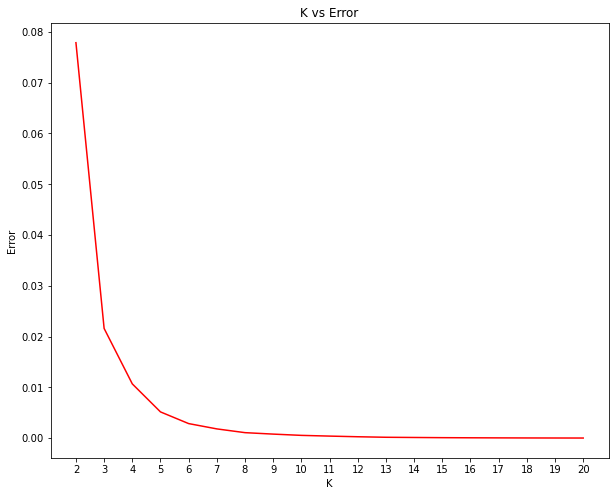

In [37]:
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores, color='r')
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")

In [38]:
from yellowbrick.cluster import KElbowVisualizer

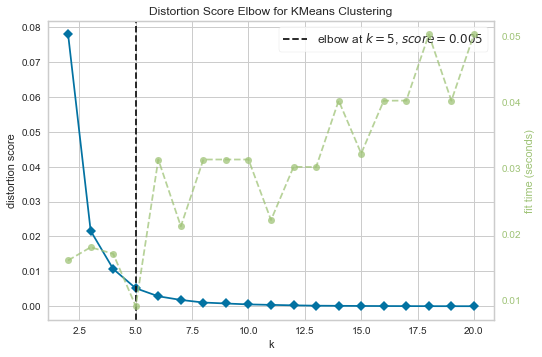

In [39]:

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,21))
visualizer.fit(X)       
visualizer.show()

In [40]:
kclusters = 5
toronto_grouped_clustering = ita.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)
kmeans.labels_[0:10]

array([0, 0, 0, 2, 3, 0, 2, 4, 0, 0])

In [41]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
to_merged = ita.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_
to_merged.head()

Neighborhood      Café  Cluster Labels
0                                        Agincourt  0.000000               0
1                           Alderwood, Long Branch  0.000000               0
2  Bathurst Manor, Wilson Heights, Downsview North  0.000000               0
3                                  Bayview Village  0.250000               2
4                Bedford Park, Lawrence Manor East  0.043478               3

In [42]:
#  we will add latitude/longitude for each neighborhood by merging toronto_grouped with toronto_data
to_merged = to_merged.join(toronto_venues.set_index("Neighborhood"), on="Neighborhood")
print(to_merged.shape)
to_merged.head()

(2110, 9)


Neighborhood  Café  Cluster Labels  Neighborhood Latitude  \
0               Agincourt   0.0               0              43.794200   
0               Agincourt   0.0               0              43.794200   
0               Agincourt   0.0               0              43.794200   
0               Agincourt   0.0               0              43.794200   
1  Alderwood, Long Branch   0.0               0              43.602414   

   Neighborhood Longitude                             Venue  Venue Latitude  \
0              -79.262029       Panagio's Breakfast & Lunch       43.792370   
0              -79.262029                     El Pulgarcito       43.792648   
0              -79.262029                          Twilight       43.791999   
0              -79.262029                   Commander Arena       43.794867   
1              -79.543484  Il Paesano Pizzeria & Restaurant       43.601280   

   Venue Longitude             Venue Category  
0       -79.260203             Breakfast Spot  
0       -79.259208  Latin American Restaurant  
0       -79.258584                     Lounge  
0       -79.267989               Skating Rink  
1       -79.545028                Pizza Place

In [43]:
# sort the merged data by Cluster Labels
print(to_merged.shape)
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged

(2110, 9)


Neighborhood     Café  Cluster Labels  \
0                        Agincourt  0.00000               0   
41  India Bazaar, The Beaches West  0.00000               0   
41  India Bazaar, The Beaches West  0.00000               0   
41  India Bazaar, The Beaches West  0.00000               0   
41  India Bazaar, The Beaches West  0.00000               0   
..                             ...      ...             ...   
84  University of Toronto, Harbord  0.15625               4   
84  University of Toronto, Harbord  0.15625               4   
84  University of Toronto, Harbord  0.15625               4   
84  University of Toronto, Harbord  0.15625               4   
14                        Christie  0.18750               4   

    Neighborhood Latitude  Neighborhood Longitude  \
0               43.794200              -79.262029   
41              43.668999              -79.315572   
41              43.668999              -79.315572   
41              43.668999              -79.315572   
41              43.668999              -79.315572   
..                    ...                     ...   
84              43.662696              -79.400049   
84              43.662696              -79.400049   
84              43.662696              -79.400049   
84              43.662696              -79.400049   
14              43.669542              -79.422564   

                          Venue  Venue Latitude  Venue Longitude  \
0   Panagio's Breakfast & Lunch       43.792370       -79.260203   
41               System Fitness       43.667171       -79.312733   
41   British Style Fish & Chips       43.668723       -79.317139   
41            Brett's Ice Cream       43.667222       -79.312831   
41                      O Sushi       43.666684       -79.316614   
..                          ...             ...              ...   
84                  Cafe Cancan       43.662735       -79.403447   
84                   Akai Sushi       43.662470       -79.404946   
84              Athletic Centre       43.662487       -79.400657   
84          Harbord Convenience       43.662627       -79.404043   
14                    Starbucks       43.671530       -79.421400   

       Venue Category  
0      Breakfast Spot  
41                Gym  
41  Fish & Chips Shop  
41     Ice Cream Shop  
41   Sushi Restaurant  
..                ...  
84  French Restaurant  
84   Sushi Restaurant  
84        College Gym  
84        Flower Shop  
14        Coffee Shop  

[2110 rows x 9 columns]

In [44]:
to_merged['Venue Category'].value_counts()['Café']

91

In [45]:
map_clusters = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Neighborhood Latitude'], to_merged['Neighborhood Longitude'], to_merged['Neighborhood'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

In [46]:
ita["Cluster Labels"] = kmeans.labels_
ita.head()

Neighborhood      Café  Cluster Labels
0                                        Agincourt  0.000000               0
1                           Alderwood, Long Branch  0.000000               0
2  Bathurst Manor, Wilson Heights, Downsview North  0.000000               0
3                                  Bayview Village  0.250000               2
4                Bedford Park, Lawrence Manor East  0.043478               3

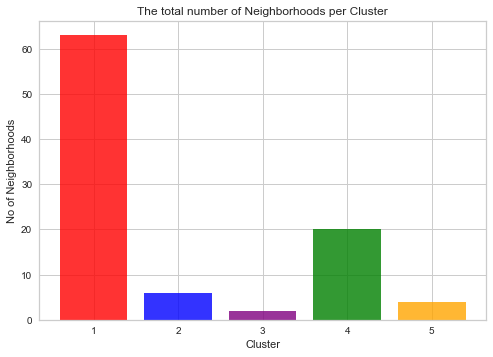

In [47]:
objects = (1,2,3,4,5)
y_pos = np.arange(len(objects))
performance = ita['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red','blue', 'purple','green', 'orange'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('The total number of Neighborhoods per Cluster')

plt.show()

In [48]:
# count of neighborhoods in each cluster
ita['Cluster Labels'].value_counts()

0    63
3    20
1     6
4     4
2     2
Name: Cluster Labels, dtype: int64

In [49]:
# We will create a dataframe by merging cluster dataframe with borough of each neighborhood 
df_new = df[['Borough', 'Neighborhood']]
df_new.head()

Borough                       Neighborhood
0  Central Toronto                      Lawrence Park
1  Central Toronto                   Davisville North
2  Central Toronto  North Toronto West, Lawrence Park
3  Central Toronto                         Davisville
4  Central Toronto        Moore Park, Summerhill East

In [50]:
# create cluster 1 dataframe
cluster1 = to_merged.loc[to_merged['Cluster Labels'] == 0]
df_cluster1 = pd.merge(df_new, cluster1, on='Neighborhood')
df_cluster1.head(10)

Borough      Neighborhood  Café  Cluster Labels  \
0  Central Toronto     Lawrence Park   0.0               0   
1  Central Toronto     Lawrence Park   0.0               0   
2  Central Toronto     Lawrence Park   0.0               0   
3  Central Toronto     Lawrence Park   0.0               0   
4  Central Toronto  Davisville North   0.0               0   
5  Central Toronto  Davisville North   0.0               0   
6  Central Toronto  Davisville North   0.0               0   
7  Central Toronto  Davisville North   0.0               0   
8  Central Toronto  Davisville North   0.0               0   
9  Central Toronto  Davisville North   0.0               0   

   Neighborhood Latitude  Neighborhood Longitude  \
0              43.728020              -79.388790   
1              43.728020              -79.388790   
2              43.728020              -79.388790   
3              43.728020              -79.388790   
4              43.712751              -79.390197   
5              43.712751              -79.390197   
6              43.712751              -79.390197   
7              43.712751              -79.390197   
8              43.712751              -79.390197   
9              43.712751              -79.390197   

                                    Venue  Venue Latitude  Venue Longitude  \
0                    Lawrence Park Ravine       43.726963       -79.394382   
1                         HYC Design Inc.       43.726793       -79.391681   
2                      Zodiac Swim School       43.728532       -79.382860   
3          TTC Bus #162 - Lawrence-Donway       43.728026       -79.382805   
4             Homeway Restaurant & Brunch       43.712641       -79.391557   
5                                 Winners       43.713236       -79.393873   
6  Best Western Roehampton Hotel & Suites       43.708878       -79.390880   
7                                  Subway       43.708474       -79.390674   
8      900 Mount Pleasant - Residents Gym       43.711671       -79.391767   
9                Provocative Pizza Series       43.708293       -79.389546   

         Venue Category  
0                  Park  
1      Business Service  
2           Swim School  
3              Bus Line  
4        Breakfast Spot  
5      Department Store  
6                 Hotel  
7        Sandwich Place  
8  Gym / Fitness Center  
9           Pizza Place

In [51]:
#cluster 2 dataframe
cluster2=to_merged.loc[to_merged['Cluster Labels'] == 1]
df_cluster2 = pd.merge(df_new, cluster2, on='Neighborhood')
df_cluster2.sort_values(["Café"], ascending=False)

Borough                                       Neighborhood  \
177         Etobicoke  Eringate, Bloordale Gardens, Old Burnhamthorpe...   
186         Etobicoke  Eringate, Bloordale Gardens, Old Burnhamthorpe...   
185         Etobicoke  Eringate, Bloordale Gardens, Old Burnhamthorpe...   
184         Etobicoke  Eringate, Bloordale Gardens, Old Burnhamthorpe...   
183         Etobicoke  Eringate, Bloordale Gardens, Old Burnhamthorpe...   
..                ...                                                ...   
138  Downtown Toronto             First Canadian Place, Underground city   
139  Downtown Toronto             First Canadian Place, Underground city   
140  Downtown Toronto             First Canadian Place, Underground city   
141  Downtown Toronto             First Canadian Place, Underground city   
123  Downtown Toronto             First Canadian Place, Underground city   

     Café  Cluster Labels  Neighborhood Latitude  Neighborhood Longitude  \
177  0.10               1              43.643515              -79.577201   
186  0.10               1              43.643515              -79.577201   
185  0.10               1              43.643515              -79.577201   
184  0.10               1              43.643515              -79.577201   
183  0.10               1              43.643515              -79.577201   
..    ...             ...                    ...                     ...   
138  0.07               1              43.648429              -79.382280   
139  0.07               1              43.648429              -79.382280   
140  0.07               1              43.648429              -79.382280   
141  0.07               1              43.648429              -79.382280   
123  0.07               1              43.648429              -79.382280   

                    Venue  Venue Latitude  Venue Longitude    Venue Category  
177       Carsbrooke Park       43.647051       -79.576682              Park  
186                  LCBO       43.642099       -79.576592      Liquor Store  
185             Starbucks       43.641312       -79.576924       Coffee Shop  
184        The Beer Store       43.641313       -79.576925        Beer Store  
183    Shoppers Drug Mart       43.641312       -79.576924          Pharmacy  
..                    ...             ...              ...               ...  
138    Bosk at Shangri-La       43.649023       -79.385826  Asian Restaurant  
139  Bulldog On The Block       43.650652       -79.384141       Coffee Shop  
140     Petit Four Bakery       43.647744       -79.379588    Sandwich Place  
141    Shangri-La Toronto       43.649129       -79.386557             Hotel  
123                 Maman       43.648309       -79.382253              Café  

[246 rows x 10 columns]

In [52]:
df_cluster2['Venue Category'].value_counts(ascending=False)['Café']

19

In [53]:
cluster3 = to_merged.loc[to_merged['Cluster Labels'] == 2]
df_cluster3 = pd.merge(df_new, cluster3, on='Neighborhood')
df_cluster3

Borough                 Neighborhood  Café  Cluster Labels  \
0   North York              Bayview Village  0.25               2   
1   North York              Bayview Village  0.25               2   
2   North York              Bayview Village  0.25               2   
3   North York              Bayview Village  0.25               2   
4  Scarborough  Birch Cliff, Cliffside West  0.25               2   
5  Scarborough  Birch Cliff, Cliffside West  0.25               2   
6  Scarborough  Birch Cliff, Cliffside West  0.25               2   
7  Scarborough  Birch Cliff, Cliffside West  0.25               2   

   Neighborhood Latitude  Neighborhood Longitude  \
0              43.786947              -79.385975   
1              43.786947              -79.385975   
2              43.786947              -79.385975   
3              43.786947              -79.385975   
4              43.692657              -79.264848   
5              43.692657              -79.264848   
6              43.692657              -79.264848   
7              43.692657              -79.264848   

                           Venue  Venue Latitude  Venue Longitude  \
0                     Kaga Sushi       43.787758       -79.381090   
1    Maxim's Cafe and Patisserie       43.787863       -79.380751   
2                TD Canada Trust       43.788074       -79.380367   
3  Sun Star Chinese Cuisine 翠景小炒       43.787914       -79.381234   
4    Birchmount Community Centre       43.695175       -79.262161   
5            Scarborough Gardens       43.694647       -79.262230   
6             Birchmount Stadium       43.695323       -79.261293   
7                 The Birchcliff       43.691666       -79.264532   

          Venue Category  
0    Japanese Restaurant  
1                   Café  
2                   Bank  
3     Chinese Restaurant  
4  General Entertainment  
5           Skating Rink  
6        College Stadium  
7                   Café

In [54]:
cluster4 = to_merged.loc[to_merged['Cluster Labels'] == 3]
df_cluster4 = pd.merge(df_new, cluster4, on='Neighborhood')
df_cluster4

Borough                       Neighborhood      Café  \
0     Central Toronto  North Toronto West, Lawrence Park  0.055556   
1     Central Toronto  North Toronto West, Lawrence Park  0.055556   
2     Central Toronto  North Toronto West, Lawrence Park  0.055556   
3     Central Toronto  North Toronto West, Lawrence Park  0.055556   
4     Central Toronto  North Toronto West, Lawrence Park  0.055556   
...               ...                                ...       ...   
1182     West Toronto           Little Portugal, Trinity  0.047619   
1183     West Toronto           Little Portugal, Trinity  0.047619   
1184     West Toronto           Little Portugal, Trinity  0.047619   
1185     West Toronto           Little Portugal, Trinity  0.047619   
1186     West Toronto           Little Portugal, Trinity  0.047619   

      Cluster Labels  Neighborhood Latitude  Neighborhood Longitude  \
0                  3              43.715383              -79.405678   
1                  3              43.715383              -79.405678   
2                  3              43.715383              -79.405678   
3                  3              43.715383              -79.405678   
4                  3              43.715383              -79.405678   
...              ...                    ...                     ...   
1182               3              43.647927              -79.419750   
1183               3              43.647927              -79.419750   
1184               3              43.647927              -79.419750   
1185               3              43.647927              -79.419750   
1186               3              43.647927              -79.419750   

                              Venue  Venue Latitude  Venue Longitude  \
0                  Blo Blow Dry Bar       43.714712       -79.400227   
1     St. Clements - Yonge Parkette       43.712062       -79.404255   
2                        Second Cup       43.714583       -79.400120   
3                               GAP       43.715450       -79.400089   
4                       Tim Hortons       43.714894       -79.399776   
...                             ...             ...              ...   
1182                    Rotate This       43.648544       -79.420518   
1183                         Bazara       43.648535       -79.420521   
1184                       Get Well       43.649320       -79.421937   
1185       The Communist's Daughter       43.649362       -79.420963   
1186                   Lost & Found       43.649378       -79.424149   

               Venue Category  
0     Health & Beauty Service  
1                        Park  
2                        Café  
3              Clothing Store  
4                 Coffee Shop  
...                       ...  
1182              Record Shop  
1183      Japanese Restaurant  
1184                      Bar  
1185                      Bar  
1186              Men's Store  

[1187 rows x 10 columns]

In [55]:
cluster5 = to_merged.loc[to_merged['Cluster Labels'] == 4]
df_cluster5 = pd.merge(df_new, cluster5, on='Neighborhood')
df_cluster5

Borough                                  Neighborhood      Café  \
0   Central Toronto           The Annex, North Midtown, Yorkville  0.157895   
1   Central Toronto           The Annex, North Midtown, Yorkville  0.157895   
2   Central Toronto           The Annex, North Midtown, Yorkville  0.157895   
3   Central Toronto           The Annex, North Midtown, Yorkville  0.157895   
4   Central Toronto           The Annex, North Midtown, Yorkville  0.157895   
..              ...                                           ...       ...   
84     West Toronto  Brockton, Parkdale Village, Exhibition Place  0.136364   
85     West Toronto  Brockton, Parkdale Village, Exhibition Place  0.136364   
86     West Toronto  Brockton, Parkdale Village, Exhibition Place  0.136364   
87     West Toronto  Brockton, Parkdale Village, Exhibition Place  0.136364   
88     West Toronto  Brockton, Parkdale Village, Exhibition Place  0.136364   

    Cluster Labels  Neighborhood Latitude  Neighborhood Longitude  \
0                4              43.672710              -79.405678   
1                4              43.672710              -79.405678   
2                4              43.672710              -79.405678   
3                4              43.672710              -79.405678   
4                4              43.672710              -79.405678   
..             ...                    ...                     ...   
84               4              43.636847              -79.428191   
85               4              43.636847              -79.428191   
86               4              43.636847              -79.428191   
87               4              43.636847              -79.428191   
88               4              43.636847              -79.428191   

                          Venue  Venue Latitude  Venue Longitude  \
0          The Annex Hodgepodge       43.674975       -79.406543   
1                       Fet Zun       43.675147       -79.406346   
2              Toronto Archives       43.676447       -79.407509   
3           Dish Cooking Studio       43.674066       -79.410764   
4    Krispy Kreme Doughnut Cafe       43.674732       -79.407730   
..                          ...             ...              ...   
84                     Uma Cafe       43.637016       -79.424048   
85            Queen Supermarket       43.634265       -79.429112   
86             Cinema Nightclub       43.637614       -79.423890   
87  Gardiner Expy & Dufferin St       43.633800       -79.425460   
88            Dunn Milk Variety       43.633667       -79.431549   

               Venue Category  
0              Sandwich Place  
1   Middle Eastern Restaurant  
2              History Museum  
3                        Café  
4                  Donut Shop  
..                        ...  
84                       Café  
85              Grocery Store  
86                  Nightclub  
87               Intersection  
88          Convenience Store  

[89 rows x 10 columns]

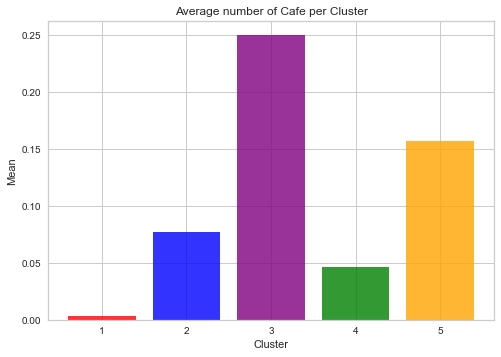

In [56]:
clusters_mean = [df_cluster1['Café'].mean(),df_cluster2['Café'].mean(),df_cluster3['Café'].mean(),
                 df_cluster4['Café'].mean(),df_cluster5['Café'].mean()]
objects = (1,2,3,4,5)
y_pos = np.arange(len(objects))
perf = clusters_mean
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'blue', 'purple','green', 'orange'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Cafe per Cluster')

plt.show()

In [57]:
)

SyntaxError: invalid syntax (<ipython-input-57-a35077a93b18>, line 1)